<a href="https://colab.research.google.com/github/datdiego/qubit_dyamics/blob/main/notebooks/training_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qutip
!pip install qutip-qtrl
!pip install qutip-qip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.0/130.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi
import qutip as qt
import pandas as pd
from qutip import *
from qutip_qtrl import *
from qutip_qip.operations import *
from numpy import pi
from qutip_qtrl.grape import plot_grape_control_fields, _overlap
from qutip_qtrl.cy_grape import cy_overlap
from qutip_qtrl.grape import cy_grape_unitary, grape_unitary_adaptive
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [ ]:
# Define parameters
num_time_slices = 100  # Number of time slices for each GRAPE run
evo_time = 1.0  # Total evolution time
t_list = np.linspace(0, evo_time, num_time_slices)  # Time range
eps = 2 * np.pi / evo_time  # Epsilon scaling for GRAPE

# Define Hamiltonian components
H0 = 0 * np.pi * sigmaz()  # Drift Hamiltonian set to zero
H_ops = [sigmax(), sigmay(), sigmaz()]  # Control operators for x, y, and z directions
R = 150

# Define the initial state (always starting from |0⟩)
psi0 = basis(2, 0)

# List to store all data (target_unitary, control fields, expectation values)
dataset = []

# Define specific target unitaries as rotations to reach each basis and superposition state
specific_target_angles = [
    (0, 0),            # Identity rotation (target |0⟩)
    (0, np.pi),        # π rotation around x-axis (target |1⟩)
    (np.pi/2, np.pi),  # π rotation followed by π/2 around z-axis (target |+⟩)
    (-np.pi/2, np.pi), # π rotation followed by -π/2 around z-axis (target |-⟩)
]

H_labels = ['u_x', 'u_y', 'u_z']

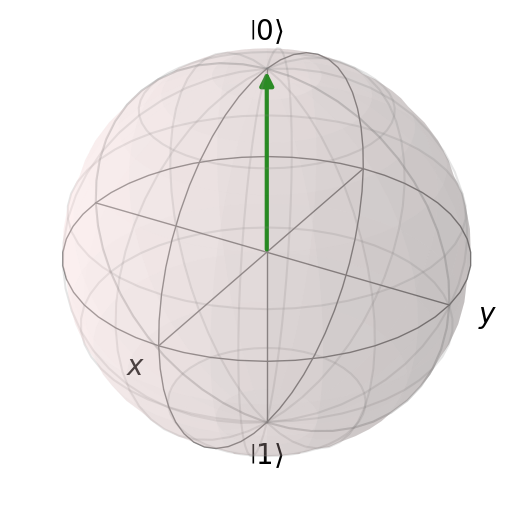

In [ ]:
b = Bloch()
b2 = Bloch()
b.add_states(psi0)
b2.add_states(psi0)
b.show()

In [ ]:
# Generate data for each of these specific target unitaries
for phi, theta in specific_target_angles:

    # Target Unitaries
    U = rz(phi) * rx(theta)
    b.add_states(U * psi0)
    b2.add_states(U * psi0)

    # Initial guess for control fields with smoothing
    u0 = np.array([np.random.rand(len(t_list)) * 2 * np.pi * 0.005 for _ in range(len(H_ops))])
    u0 = [np.convolve(np.ones(10)/10, u0[idx, :], mode='same') for idx in range(len(H_ops))]

    # Run cy_grape_unitary to find the optimal control fields for reaching the target unitary
    result = cy_grape_unitary(
        U, H0, H_ops, R, t_list, u_start=u0, eps=eps,
        phase_sensitive=False
    )

    # Get control fields from the last iteration
    # result.u[-1] contains the control fields for the last iteration
    last_iteration_u = result.u[-1]  # Shape: (3, num_time_slices)

    # Reshape the 2D array to align with the data structure
    reshaped_u = last_iteration_u.T  # Shape: (num_time_slices, 3)
    data_entry_df = pd.DataFrame(reshaped_u / (2 * np.pi), columns=H_labels)
    data_entry_df['time'] = t_list
    data_entry_df['theta'] = theta
    data_entry_df['phi'] = phi

    # Solve for dynamics to get expectation values ⟨σx⟩, ⟨σy⟩, and ⟨σz⟩ over time
    e_ops = [sigmax(), sigmay(), sigmaz()]
    me_result = mesolve(result.H_t, psi0, t_list, c_ops=[], e_ops=e_ops)

    # Add points to Bloch sphere
    b2.add_points(me_result.expect)

    # Collect expectation values in the dataframe
    data_entry_df['sigmax_expect'] = me_result.expect[0]
    data_entry_df['sigmay_expect'] = me_result.expect[1]
    data_entry_df['sigmaz_expect'] = me_result.expect[2]

    # Append to dataset
    dataset.append(data_entry_df)

In [ ]:
print(last_iteration_u.shape)
print(result.u.shape)


(3, 100)
(150, 3, 100)


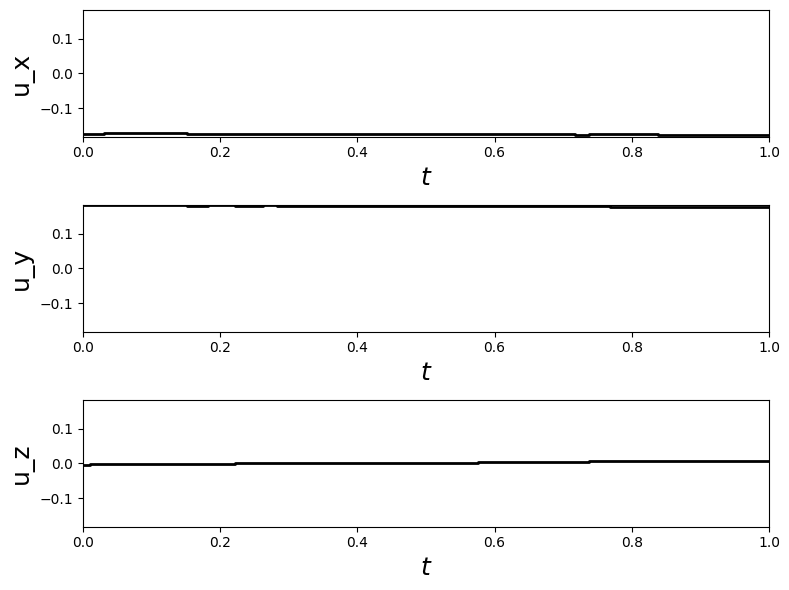

In [ ]:
# plot the last iteration of the result_u
plot_grape_control_fields(t_list, result.u[-1:,:,:] / (2 * pi), H_labels, uniform_axes=True);


In [ ]:
print(result.u.shape)
print(reshaped_u.shape)
print(data_entry_df.shape)
data_entry_df.head(10)


(150, 3, 100)
(100, 3)
(100, 9)


,u_x,u_y,u_z,time,theta,phi,sigmax_expect,sigmay_expect,sigmaz_expect
0,-0.173496,0.180689,-0.003737,0.000000,3.141593,-1.570796,0.000000,0.000000,1.000000
1,-0.173156,0.180949,-0.003346,0.010101,3.141593,-1.570796,0.022949,0.021983,0.999495
2,-0.173167,0.181229,-0.002796,0.020202,3.141593,-1.570796,0.045924,0.043925,0.997979
3,-0.172821,0.181218,-0.002469,0.030303,3.141593,-1.570796,0.068871,0.065798,0.995453
4,-0.172394,0.181607,-0.002081,0.040404,3.141593,-1.570796,0.091775,0.087547,0.991924
5,-0.172223,0.181708,-0.001574,0.050505,3.141593,-1.570796,0.114624,0.109168,0.987392
6,-0.172096,0.181636,-0.001501,0.060606,3.141593,-1.570796,0.137352,0.130664,0.981866
7,-0.171744,0.181915,-0.000998,0.070707,3.141593,-1.570796,0.159958,0.151998,0.975351
8,-0.171695,0.181565,-0.001189,0.080808,3.141593,-1.570796,0.182399,0.173148,0.967859
9,-0.172074,0.181480,-0.000933,0.090909,3.141593,-1.570796,0.204628,0.194150,0.959392


In [ ]:
print(result.u.shape)
print(reshaped_u.shape)
print(data_entry_df)
data_entry_df.head(10)



(150, 3, 100)
(100, 3)
         u_x       u_y       u_z      time     theta       phi  sigmax_expect  \
0  -0.173496  0.180689 -0.003737  0.000000  3.141593 -1.570796       0.000000   
1  -0.173156  0.180949 -0.003346  0.010101  3.141593 -1.570796       0.022949   
2  -0.173167  0.181229 -0.002796  0.020202  3.141593 -1.570796       0.045924   
3  -0.172821  0.181218 -0.002469  0.030303  3.141593 -1.570796       0.068871   
4  -0.172394  0.181607 -0.002081  0.040404  3.141593 -1.570796       0.091775   
..       ...       ...       ...       ...       ...       ...            ...   
95 -0.176450  0.176425  0.007602  0.959596  3.141593 -1.570796       0.089162   
96 -0.176702  0.176018  0.007531  0.969697  3.141593 -1.570796       0.066855   
97 -0.177194  0.175966  0.007383  0.979798  3.141593 -1.570796       0.044537   
98 -0.177333  0.175857  0.007255  0.989899  3.141593 -1.570796       0.022201   
99 -0.177333  0.175857  0.007255  1.000000  3.141593 -1.570796      -0.000124   

    

,u_x,u_y,u_z,time,theta,phi,sigmax_expect,sigmay_expect,sigmaz_expect
0,-0.173496,0.180689,-0.003737,0.000000,3.141593,-1.570796,0.000000,0.000000,1.000000
1,-0.173156,0.180949,-0.003346,0.010101,3.141593,-1.570796,0.022949,0.021983,0.999495
2,-0.173167,0.181229,-0.002796,0.020202,3.141593,-1.570796,0.045924,0.043925,0.997979
3,-0.172821,0.181218,-0.002469,0.030303,3.141593,-1.570796,0.068871,0.065798,0.995453
4,-0.172394,0.181607,-0.002081,0.040404,3.141593,-1.570796,0.091775,0.087547,0.991924
5,-0.172223,0.181708,-0.001574,0.050505,3.141593,-1.570796,0.114624,0.109168,0.987392
6,-0.172096,0.181636,-0.001501,0.060606,3.141593,-1.570796,0.137352,0.130664,0.981866
7,-0.171744,0.181915,-0.000998,0.070707,3.141593,-1.570796,0.159958,0.151998,0.975351
8,-0.171695,0.181565,-0.001189,0.080808,3.141593,-1.570796,0.182399,0.173148,0.967859
9,-0.172074,0.181480,-0.000933,0.090909,3.141593,-1.570796,0.204628,0.194150,0.959392


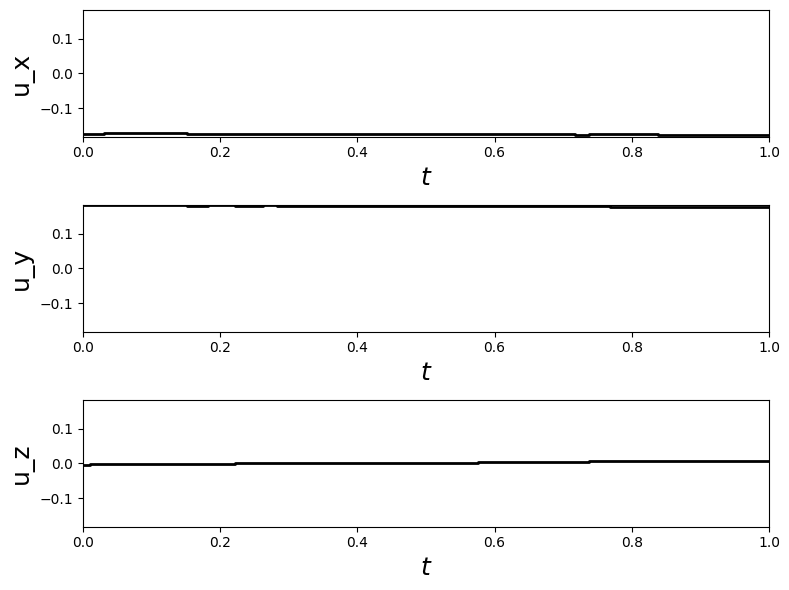

In [ ]:
plot_grape_control_fields(t_list, result.u[-1:,:,:] / (2 * pi), H_labels, uniform_axes=True);

In [ ]:
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2


(-0.9999999999154299, 0.9999999998308597)

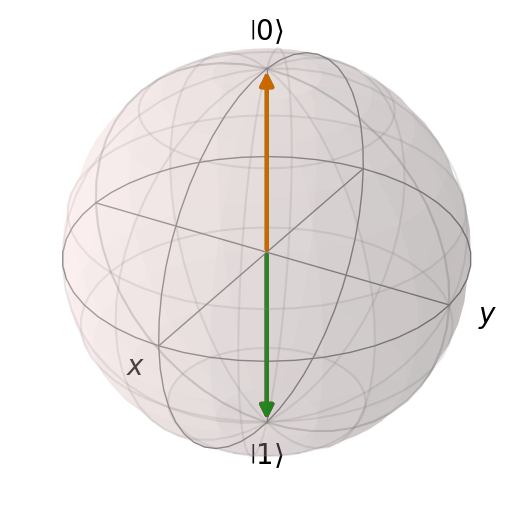

In [ ]:
b.show()

In [ ]:
saved_rotation = []
# Generate additional random target unitaries for variety
for i in range(496):  # 100 total unitaries minus the 4 basis-related ones
    # Random rotation angles for rz and rx to create a random target unitary


    phi = np.random.uniform(0, 2 * np.pi)
    theta = np.random.uniform(0, 2 * np.pi)

    # if the combination of both not generated before continue else redo generation of random rotation
    while (phi, theta) in saved_rotation:
        phi = np.random.uniform(0, 2 * np.pi)
        theta = np.random.uniform(0, 2 * np.pi)
    saved_rotation.append((phi, theta))


    # Target Unitaries
    U = rz(phi) * rx(theta)
    b.add_states(U * psi0)
    b2.add_states(U * psi0)

    # Initial guess for control fields with smoothing
    u0 = np.array([np.random.rand(len(t_list)) * 2 * np.pi * 0.005 for _ in range(len(H_ops))])
    u0 = [np.convolve(np.ones(10)/10, u0[idx, :], mode='same') for idx in range(len(H_ops))]

    # Run cy_grape_unitary to find the optimal control fields for reaching the target unitary
    result = cy_grape_unitary(
        U, H0, H_ops, R, t_list, u_start=u0, eps=eps,
        phase_sensitive=False
    )

    # Get control fields from the last iteration
    # result.u[-1] contains the control fields for the last iteration
    last_iteration_u = result.u[-1]  # Shape: (3, num_time_slices)

    # Reshape the 2D array to align with the data structure
    reshaped_u = last_iteration_u.T  # Shape: (num_time_slices, 3)
    data_entry_df = pd.DataFrame(reshaped_u / (2 * np.pi), columns=H_labels)
    data_entry_df['time'] = t_list
    data_entry_df['theta'] = theta
    data_entry_df['phi'] = phi

    # Solve for dynamics to get expectation values ⟨σx⟩, ⟨σy⟩, and ⟨σz⟩ over time
    e_ops = [sigmax(), sigmay(), sigmaz()]
    me_result = mesolve(result.H_t, psi0, t_list, c_ops=[], e_ops=e_ops)

    # Add points to Bloch sphere
    b2.add_points(me_result.expect)

    # Collect expectation values in the dataframe
    data_entry_df['sigmax_expect'] = me_result.expect[0]
    data_entry_df['sigmay_expect'] = me_result.expect[1]
    data_entry_df['sigmaz_expect'] = me_result.expect[2]

    # Append to dataset
    dataset.append(data_entry_df)


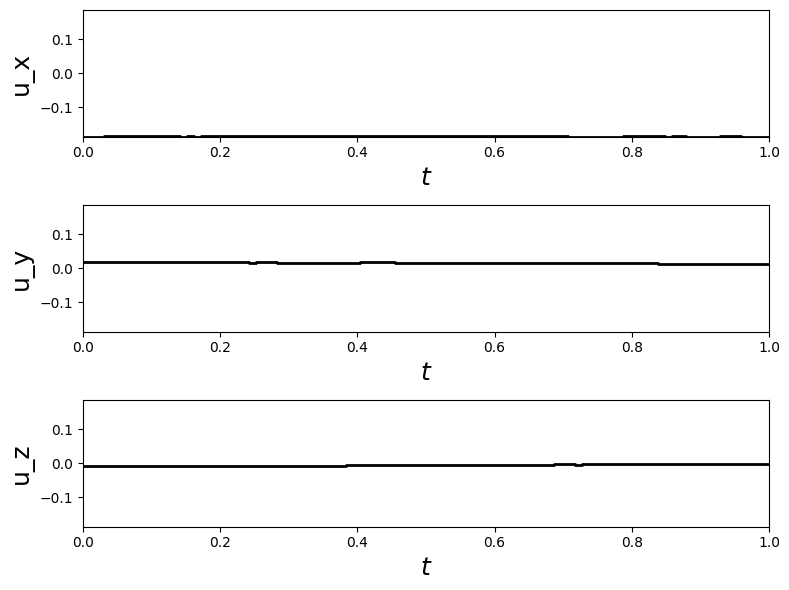

In [ ]:
plot_grape_control_fields(t_list, result.u[-1:,:,:] / (2 * pi), H_labels, uniform_axes=True);


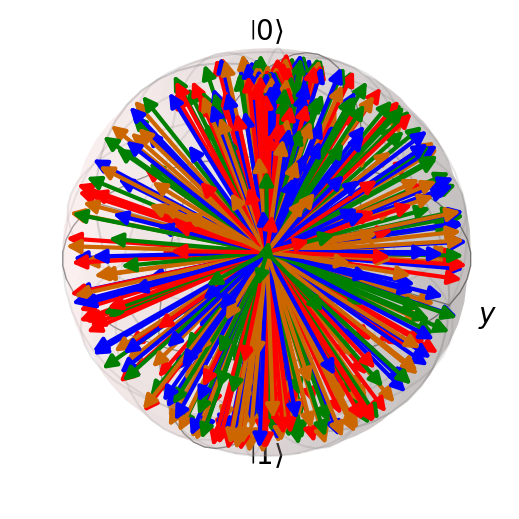

In [ ]:
b.show()

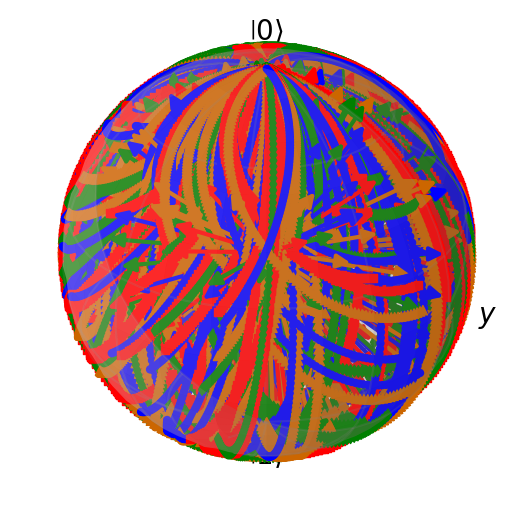

In [ ]:
b2.show()

In [ ]:
# Concatenate all dataframes into a single one
final_df = pd.concat(dataset, ignore_index=True)
final_df

,u_x,u_y,u_z,time,theta,phi,sigmax_expect,sigmay_expect,sigmaz_expect
0,-0.001147,-0.001048,-0.001176,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,-0.000953,-0.000810,-0.000919,0.010101,0.000000,0.000000,-0.000116,0.000132,1.000000
2,-0.000690,-0.000763,-0.000540,0.020202,0.000000,0.000000,-0.000214,0.000239,1.000000
3,-0.000222,-0.000752,-0.000227,0.030303,0.000000,0.000000,-0.000312,0.000295,1.000000
4,-0.000187,-0.000349,0.000156,0.040404,0.000000,0.000000,-0.000385,0.000319,1.000000
...,...,...,...,...,...,...,...,...,...
49995,-0.185793,0.013500,-0.001346,0.959596,3.942251,6.122307,0.118298,0.771318,-0.625359
49996,-0.186178,0.013004,-0.001725,0.969697,3.942251,6.122307,0.117378,0.756320,-0.643586
49997,-0.186653,0.012866,-0.002114,0.979798,3.942251,6.122307,0.116491,0.740847,-0.661495
49998,-0.186688,0.012367,-0.002294,0.989899,3.942251,6.122307,0.115622,0.724929,-0.679050


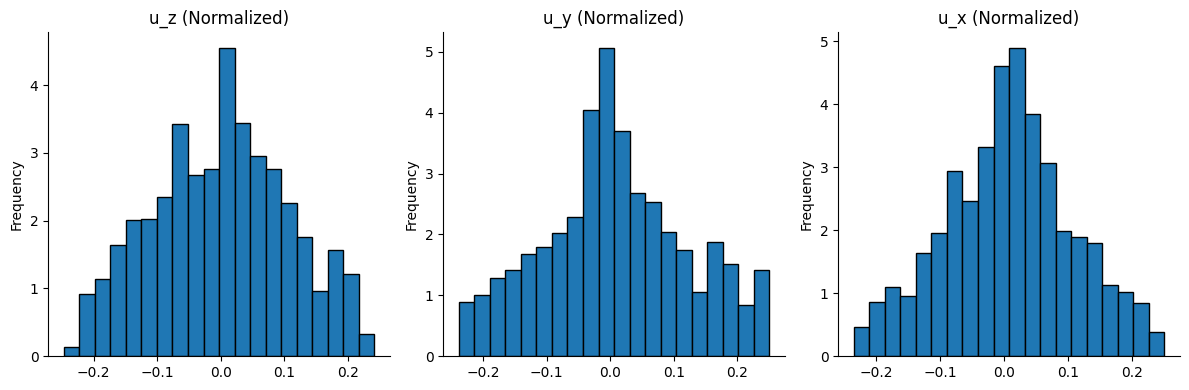

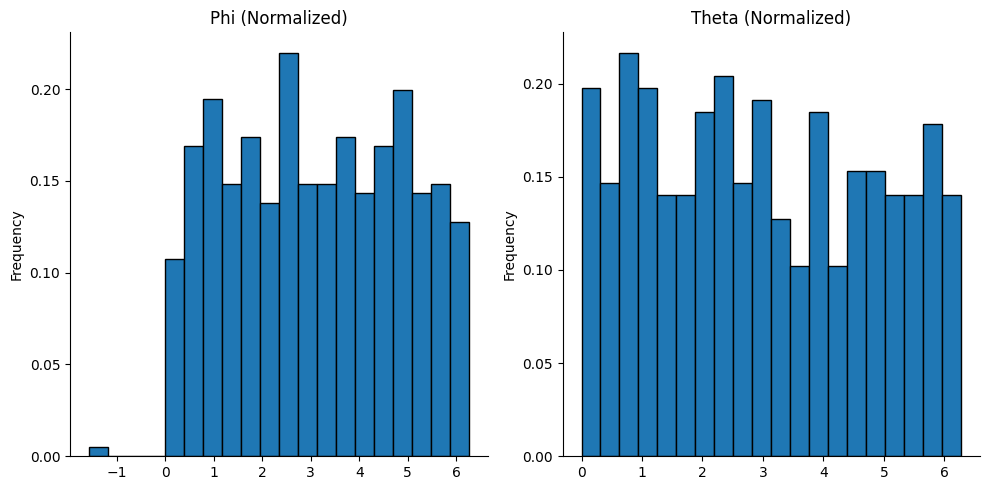

In [ ]:
# prompt: Generate histogram distributions of the angles phi, theta. and normalize.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'final_df' is already created as in the provided code

# Normalize the histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
final_df['u_z'].plot(kind='hist', bins=20, density=True, title='u_z (Normalized)', edgecolor='black')
plt.gca().spines[['top', 'right']].set_visible(False)

plt.subplot(1, 3, 2)
final_df['u_y'].plot(kind='hist', bins=20, density=True, title='u_y (Normalized)', edgecolor='black')
plt.gca().spines[['top', 'right']].set_visible(False)

plt.subplot(1, 3, 3)
final_df['u_x'].plot(kind='hist', bins=20, density=True, title='u_x (Normalized)', edgecolor='black')
plt.gca().spines[['top', 'right']].set_visible(False)


plt.tight_layout()
plt.show()

# Generate histogram distributions of phi and theta (normalized)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
final_df['phi'].plot(kind='hist', bins=20, density=True, title='Phi (Normalized)', edgecolor='black')
plt.gca().spines[['top', 'right']].set_visible(False)

plt.subplot(1, 2, 2)
final_df['theta'].plot(kind='hist', bins=20, density=True, title='Theta (Normalized)', edgecolor='black')
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
final_df.head(10)

,u_x,u_y,u_z,time,theta,phi,sigmax_expect,sigmay_expect,sigmaz_expect
0,-0.001147,-0.001048,-0.001176,0.000000,0.0,0.0,0.000000,0.000000,1.0
1,-0.000953,-0.000810,-0.000919,0.010101,0.0,0.0,-0.000116,0.000132,1.0
2,-0.000690,-0.000763,-0.000540,0.020202,0.0,0.0,-0.000214,0.000239,1.0
3,-0.000222,-0.000752,-0.000227,0.030303,0.0,0.0,-0.000312,0.000295,1.0
4,-0.000187,-0.000349,0.000156,0.040404,0.0,0.0,-0.000385,0.000319,1.0
5,-0.000070,0.000002,0.000388,0.050505,0.0,0.0,-0.000403,0.000333,1.0
6,-0.000428,-0.000201,0.000196,0.060606,0.0,0.0,-0.000411,0.000363,1.0
7,-0.000490,-0.000414,0.000141,0.070707,0.0,0.0,-0.000454,0.000425,1.0
8,-0.000463,-0.000315,-0.000112,0.080808,0.0,0.0,-0.000501,0.000485,1.0
9,-0.000354,-0.000457,-0.000194,0.090909,0.0,0.0,-0.000546,0.000539,1.0


In [ ]:
# save in drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# save as csv
final_df.to_csv('/content/drive/MyDrive/quantum/dataset/fields_500_opt.csv', index=False)

In [ ]:
# what are the columns
final_df.columns